In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

3


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.03,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.03,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [25]:
p = Pool(4,maxtasksperchild=1)

In [26]:
results=p.map(ff, range(1,40),chunksize=1)

5


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 14.804288


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


6


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 9119 records out of 9119 records


no valid set


1575


0


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 15.133374


(829, 517, 18)


(829, 517, 32)


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


train/valid # (311610, 2) (78020, 2)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(9119, 1, 18) (9119, 7, 32) (9119, 1) (9119, 1)


(9119, 242) (9119,) (9119,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 9948 records out of 9948 records


no valid set


1575


0


[0]	train-rmse:2.37224	valid-rmse:2.37941


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(9948, 1, 18) (9948, 7, 32) (9948, 1) (9948, 1)


(9948, 242) (9948,) (9948,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.36511	valid-rmse:2.37596


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[50]	train-rmse:0.715837	valid-rmse:0.736165


[50]	train-rmse:0.715795	valid-rmse:0.739263


[100]	train-rmse:0.500451	valid-rmse:0.537489


[100]	train-rmse:0.501622	valid-rmse:0.54119


[150]	train-rmse:0.475958	valid-rmse:0.522325


[150]	train-rmse:0.477135	valid-rmse:0.52551


7


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 16.310143


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 10777 records out of 10777 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(10777, 1, 18) (10777, 7, 32) (10777, 1) (10777, 1)


(10777, 242) (10777,) (10777,)


[200]	train-rmse:0.467036	valid-rmse:0.52255


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[200]	train-rmse:0.46604	valid-rmse:0.519561


[0]	train-rmse:2.38018	valid-rmse:2.39592


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


8


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 17.574337


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 11606 records out of 11606 records


no valid set


1575


0


[250]	train-rmse:0.459239	valid-rmse:0.521451


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(11606, 1, 18) (11606, 7, 32) (11606, 1) (11606, 1)


(11606, 242) (11606,) (11606,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.3924	valid-rmse:2.40937


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[250]	train-rmse:0.459017	valid-rmse:0.518362


[50]	train-rmse:0.716024	valid-rmse:0.739794


[300]	train-rmse:0.452627	valid-rmse:0.520647


[300]	train-rmse:0.451881	valid-rmse:0.517623


[350]	train-rmse:0.446817	valid-rmse:0.520208


[100]	train-rmse:0.498864	valid-rmse:0.536654


[50]	train-rmse:0.718705	valid-rmse:0.740583


[400]	train-rmse:0.441308	valid-rmse:0.5198


[350]	train-rmse:0.445389	valid-rmse:0.517049


[150]	train-rmse:0.474204	valid-rmse:0.520497


[450]	train-rmse:0.43536	valid-rmse:0.51946


[100]	train-rmse:0.499447	valid-rmse:0.533785


[200]	train-rmse:0.464288	valid-rmse:0.517426


[400]	train-rmse:0.439836	valid-rmse:0.516718


[500]	train-rmse:0.429771	valid-rmse:0.519195


[150]	train-rmse:0.473916	valid-rmse:0.516771


[250]	train-rmse:0.457039	valid-rmse:0.516373


[450]	train-rmse:0.433855	valid-rmse:0.516364


[550]	train-rmse:0.42441	valid-rmse:0.519126


[300]	train-rmse:0.449949	valid-rmse:0.515706


[200]	train-rmse:0.463824	valid-rmse:0.513924


[500]	train-rmse:0.428774	valid-rmse:0.516166


[600]	train-rmse:0.419269	valid-rmse:0.518931


[350]	train-rmse:0.444099	valid-rmse:0.515472


[250]	train-rmse:0.455978	valid-rmse:0.512767


[650]	train-rmse:0.413957	valid-rmse:0.518851


[550]	train-rmse:0.423531	valid-rmse:0.51606


[400]	train-rmse:0.438245	valid-rmse:0.515195


[700]	train-rmse:0.409147	valid-rmse:0.518791


[300]	train-rmse:0.449551	valid-rmse:0.512041


[600]	train-rmse:0.418279	valid-rmse:0.515916


Stopping. Best iteration:
[674]	train-rmse:0.411647	valid-rmse:0.518774



0.16945301 0.26912692


[0.26912692]


-1 mean score 0.26912692


0.17134128511


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911072  0.018038  0.191817    7  2017-04-16
472     2.507290  2.521319 -0.014028  0.178643    1  2017-04-17
473     2.661330  2.639081  0.022249  0.192675    2  2017-04-18
474     2.754815  2.737003  0.017812  0.169833    3  2017-04-19
475     2.713762  2.707114  0.006648  0.183971    4  2017-04-20
476     2.999000  2.980030  0.018969  0.129780    5  2017-04-21
477     3.075529  3.090859 -0.015330  0.152670    6  2017-04-22

0.17134128511


pred         y     error    error2  day        date
dayidx                                                         
471     2.911072  2.929110  0.018038  0.191817    7  2017-04-16
472     2.521319  2.507290 -0.014028  0.178643    1  2017-04-17
473     2.639081  2.661330  0.022249  0.192675    2  2017-04-18
474     2.737003  2.754815  0.017812  0.169833    3  2017-04-19
475     2.707114  2.713762  0.006648  0.183971    4  2017-04-20
476     2.980030  2.999000  0.018969  0.129780    5  2017-04-21
477     3.090859  3.075529 -0.015330  0.152670    6  2017-04-22

(829, 242)


9


(1, 829, 517) (60, 829, 517)


[450]	train-rmse:0.432505	valid-rmse:0.514801


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 18.806503


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 12435 records out of 12435 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[350]	train-rmse:0.443508	valid-rmse:0.511687


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(12435, 1, 18) (12435, 7, 32) (12435, 1) (12435, 1)


(12435, 242) (12435,) (12435,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[650]	train-rmse:0.41356	valid-rmse:0.515819


[0]	train-rmse:2.39154	valid-rmse:2.40986


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[500]	train-rmse:0.427395	valid-rmse:0.514577


[400]	train-rmse:0.437841	valid-rmse:0.511375


[700]	train-rmse:0.408361	valid-rmse:0.515741


[550]	train-rmse:0.421854	valid-rmse:0.514367


[50]	train-rmse:0.722762	valid-rmse:0.746176


Stopping. Best iteration:
[675]	train-rmse:0.410893	valid-rmse:0.515721



0.16883299 0.26596865


[0.26596865]


-1 mean score 0.26596865


0.168578892946


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901620  0.027490  0.180797    7  2017-04-16
472     2.507290  2.509626 -0.002336  0.178769    1  2017-04-17
473     2.661330  2.647352  0.013978  0.182786    2  2017-04-18
474     2.754815  2.742018  0.012797  0.165206    3  2017-04-19
475     2.713762  2.716622 -0.002861  0.197376    4  2017-04-20
476     2.999000  2.989202  0.009798  0.131671    5  2017-04-21
477     3.075529  3.077224 -0.001695  0.143447    6  2017-04-22

0.168578892946


pred         y     error    error2  day        date
dayidx                                                         
471     2.901620  2.929110  0.027490  0.180797    7  2017-04-16
472     2.509626  2.507290 -0.002336  0.178769    1  2017-04-17
473     2.647352  2.661330  0.013978  0.182786    2  2017-04-18
474     2.742018  2.754815  0.012797  0.165206    3  2017-04-19
475     2.716622  2.713762 -0.002861  0.197376    4  2017-04-20
476     2.989202  2.999000  0.009798  0.131671    5  2017-04-21
477     3.077224  3.075529 -0.001695  0.143447    6  2017-04-22

(829, 242)


10


(1, 829, 517) (60, 829, 517)


[450]	train-rmse:0.432389	valid-rmse:0.511145


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 19.926521


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 13264 records out of 13264 records


no valid set


1575


0


[600]	train-rmse:0.416971	valid-rmse:0.514345


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(13264, 1, 18) (13264, 7, 32) (13264, 1) (13264, 1)


(13264, 242) (13264,) (13264,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.38295	valid-rmse:2.40264


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[100]	train-rmse:0.504489	valid-rmse:0.542323


[500]	train-rmse:0.427364	valid-rmse:0.510979


[650]	train-rmse:0.412009	valid-rmse:0.514194


[700]	train-rmse:0.407478	valid-rmse:0.514193


[150]	train-rmse:0.478346	valid-rmse:0.525335


[550]	train-rmse:0.42224	valid-rmse:0.510794


[50]	train-rmse:0.723335	valid-rmse:0.747523


[750]	train-rmse:0.402876	valid-rmse:0.514086


[600]	train-rmse:0.416911	valid-rmse:0.510611


[200]	train-rmse:0.467758	valid-rmse:0.522381


[100]	train-rmse:0.507138	valid-rmse:0.545054


[800]	train-rmse:0.398436	valid-rmse:0.514072


[650]	train-rmse:0.412498	valid-rmse:0.510571


[250]	train-rmse:0.458954	valid-rmse:0.521214


[850]	train-rmse:0.394242	valid-rmse:0.514021


[150]	train-rmse:0.480697	valid-rmse:0.528117


[700]	train-rmse:0.408185	valid-rmse:0.510433


[300]	train-rmse:0.45201	valid-rmse:0.520604


Stopping. Best iteration:
[826]	train-rmse:0.396215	valid-rmse:0.51399



0.15698631 0.26418528


[0.26418528]


-1 mean score 0.26418528


0.167925462127


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913375  0.015735  0.189164    7  2017-04-16
472     2.507290  2.533623 -0.026333  0.177847    1  2017-04-17
473     2.661330  2.651970  0.009360  0.182137    2  2017-04-18
474     2.754815  2.738273  0.016542  0.168680    3  2017-04-19
475     2.713762  2.700215  0.013547  0.181202    4  2017-04-20
476     2.999000  2.986273  0.012727  0.119957    5  2017-04-21
477     3.075529  3.106357 -0.030827  0.156491    6  2017-04-22

0.167925462127


pred         y     error    error2  day        date
dayidx                                                         
471     2.913375  2.929110  0.015735  0.189164    7  2017-04-16
472     2.533623  2.507290 -0.026333  0.177847    1  2017-04-17
473     2.651970  2.661330  0.009360  0.182137    2  2017-04-18
474     2.738273  2.754815  0.016542  0.168680    3  2017-04-19
475     2.700215  2.713762  0.013547  0.181202    4  2017-04-20
476     2.986273  2.999000  0.012727  0.119957    5  2017-04-21
477     3.106357  3.075529 -0.030827  0.156491    6  2017-04-22

(829, 242)


11


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 21.05768


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


[200]	train-rmse:0.469913	valid-rmse:0.525313


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 14093 records out of 14093 records


no valid set


1575


0


[750]	train-rmse:0.403923	valid-rmse:0.510344


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(14093, 1, 18) (14093, 7, 32) (14093, 1) (14093, 1)


(14093, 242) (14093,) (14093,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[350]	train-rmse:0.445204	valid-rmse:0.520203


[0]	train-rmse:2.37572	valid-rmse:2.3921


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


Stopping. Best iteration:
[734]	train-rmse:0.405089	valid-rmse:0.510317



[250]	train-rmse:0.461776	valid-rmse:0.52408


0.16409731 0.26042354


[0.26042354]


-1 mean score 0.26042354


[400]	train-rmse:0.439117	valid-rmse:0.519795


0.175548121333


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.939925 -0.010815  0.204253    7  2017-04-16
472     2.507290  2.547049 -0.039758  0.192034    1  2017-04-17
473     2.661330  2.644554  0.016776  0.194470    2  2017-04-18
474     2.754815  2.742534  0.012281  0.178769    3  2017-04-19
475     2.713762  2.704128  0.009634  0.185286    4  2017-04-20
476     2.999000  2.964423  0.034577  0.126554    5  2017-04-21
477     3.075529  3.089594 -0.014065  0.147470    6  2017-04-22

0.175548121333


pred         y     error    error2  day        date
dayidx                                                         
471     2.939925  2.929110 -0.010815  0.204253    7  2017-04-16
472     2.547049  2.507290 -0.039758  0.192034    1  2017-04-17
473     2.644554  2.661330  0.016776  0.194470    2  2017-04-18
474     2.742534  2.754815  0.012281  0.178769    3  2017-04-19
475     2.704128  2.713762  0.009634  0.185286    4  2017-04-20
476     2.964423  2.999000  0.034577  0.126554    5  2017-04-21
477     3.089594  3.075529 -0.014065  0.147470    6  2017-04-22

(829, 242)


12


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 22.115147


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 14922 records out of 14922 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(14922, 1, 18) (14922, 7, 32) (14922, 1) (14922, 1)


(14922, 242) (14922,) (14922,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[300]	train-rmse:0.453678	valid-rmse:0.523337


[0]	train-rmse:2.3722	valid-rmse:2.38226


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[450]	train-rmse:0.433796	valid-rmse:0.519606


[50]	train-rmse:0.722804	valid-rmse:0.746208


[350]	train-rmse:0.446589	valid-rmse:0.522865


[500]	train-rmse:0.428716	valid-rmse:0.519518


[50]	train-rmse:0.722169	valid-rmse:0.744151


[100]	train-rmse:0.508098	valid-rmse:0.545474


[400]	train-rmse:0.440734	valid-rmse:0.52264


[550]	train-rmse:0.423742	valid-rmse:0.519326


[450]	train-rmse:0.435039	valid-rmse:0.52247


[600]	train-rmse:0.418964	valid-rmse:0.519222


[100]	train-rmse:0.508232	valid-rmse:0.54661


[150]	train-rmse:0.482536	valid-rmse:0.528997


[650]	train-rmse:0.414446	valid-rmse:0.519098


[500]	train-rmse:0.429662	valid-rmse:0.522282


[150]	train-rmse:0.482589	valid-rmse:0.530597


[200]	train-rmse:0.471559	valid-rmse:0.52558


[700]	train-rmse:0.409656	valid-rmse:0.519094


[550]	train-rmse:0.423992	valid-rmse:0.522179


Stopping. Best iteration:
[655]	train-rmse:0.413982	valid-rmse:0.519089



0.17138143 0.26945296


[0.26945296]


-1 mean score 0.26945296


0.180337384343


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.928057  0.001053  0.190937    7  2017-04-16
472     2.507290  2.533222 -0.025932  0.206798    1  2017-04-17
473     2.661330  2.665205 -0.003875  0.212192    2  2017-04-18
474     2.754815  2.737252  0.017563  0.183349    3  2017-04-19
475     2.713762  2.698794  0.014968  0.192601    4  2017-04-20
476     2.999000  2.969736  0.029263  0.130128    5  2017-04-21
477     3.075529  3.081461 -0.005932  0.146357    6  2017-04-22

0.180337384343


pred         y     error    error2  day        date
dayidx                                                         
471     2.928057  2.929110  0.001053  0.190937    7  2017-04-16
472     2.533222  2.507290 -0.025932  0.206798    1  2017-04-17
473     2.665205  2.661330 -0.003875  0.212192    2  2017-04-18
474     2.737252  2.754815  0.017563  0.183349    3  2017-04-19
475     2.698794  2.713762  0.014968  0.192601    4  2017-04-20
476     2.969736  2.999000  0.029263  0.130128    5  2017-04-21
477     3.081461  3.075529 -0.005932  0.146357    6  2017-04-22

(829, 242)


13


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 23.15517


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 15751 records out of 15751 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[200]	train-rmse:0.470924	valid-rmse:0.527225


[600]	train-rmse:0.418959	valid-rmse:0.522132


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(15751, 1, 18) (15751, 7, 32) (15751, 1) (15751, 1)


(15751, 242) (15751,) (15751,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.36518	valid-rmse:2.37544


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[250]	train-rmse:0.462341	valid-rmse:0.524554


[650]	train-rmse:0.414087	valid-rmse:0.522071


[250]	train-rmse:0.461789	valid-rmse:0.526231


[300]	train-rmse:0.454885	valid-rmse:0.523979


[700]	train-rmse:0.409175	valid-rmse:0.521962


[50]	train-rmse:0.721565	valid-rmse:0.744172


[300]	train-rmse:0.453634	valid-rmse:0.525628


[750]	train-rmse:0.404206	valid-rmse:0.521891


[350]	train-rmse:0.447234	valid-rmse:0.525265


Stopping. Best iteration:
[715]	train-rmse:0.407806	valid-rmse:0.52187



[350]	train-rmse:0.448082	valid-rmse:0.523383


0.16630577 0.27234852


[0.27234852]


-1 mean score 0.27234852


0.173076793551


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.923214  0.005896  0.183301    7  2017-04-16
472     2.507290  2.538068 -0.030777  0.182658    1  2017-04-17
473     2.661330  2.646598  0.014732  0.201269    2  2017-04-18
474     2.754815  2.751229  0.003586  0.184937    3  2017-04-19
475     2.713762  2.716441 -0.002680  0.192036    4  2017-04-20
476     2.999000  2.972786  0.026214  0.128227    5  2017-04-21
477     3.075529  3.075679 -0.000150  0.139110    6  2017-04-22

0.173076793551


pred         y     error    error2  day        date
dayidx                                                         
471     2.923214  2.929110  0.005896  0.183301    7  2017-04-16
472     2.538068  2.507290 -0.030777  0.182658    1  2017-04-17
473     2.646598  2.661330  0.014732  0.201269    2  2017-04-18
474     2.751229  2.754815  0.003586  0.184937    3  2017-04-19
475     2.716441  2.713762 -0.002680  0.192036    4  2017-04-20
476     2.972786  2.999000  0.026214  0.128227    5  2017-04-21
477     3.075679  3.075529 -0.000150  0.139110    6  2017-04-22

(829, 242)


14


(1, 829, 517) (60, 829, 517)


[100]	train-rmse:0.508873	valid-rmse:0.547391


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 24.22639


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 16580 records out of 16580 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(16580, 1, 18) (16580, 7, 32) (16580, 1) (16580, 1)


(16580, 242) (16580,) (16580,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[400]	train-rmse:0.441334	valid-rmse:0.525013


[0]	train-rmse:2.38006	valid-rmse:2.39592


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[400]	train-rmse:0.442142	valid-rmse:0.523237


[150]	train-rmse:0.482999	valid-rmse:0.531243


[450]	train-rmse:0.43623	valid-rmse:0.524899


[450]	train-rmse:0.436593	valid-rmse:0.522995


[50]	train-rmse:0.721077	valid-rmse:0.745665


[500]	train-rmse:0.43012	valid-rmse:0.52461


[200]	train-rmse:0.471839	valid-rmse:0.527996


[500]	train-rmse:0.431042	valid-rmse:0.522841


[550]	train-rmse:0.425242	valid-rmse:0.524559


[100]	train-rmse:0.50519	valid-rmse:0.544634


[250]	train-rmse:0.462555	valid-rmse:0.526717


[600]	train-rmse:0.419832	valid-rmse:0.524429


[550]	train-rmse:0.426097	valid-rmse:0.522758


[150]	train-rmse:0.479586	valid-rmse:0.528259


[300]	train-rmse:0.45527	valid-rmse:0.526123


[650]	train-rmse:0.414906	valid-rmse:0.524312


[200]	train-rmse:0.468374	valid-rmse:0.524816


[600]	train-rmse:0.421311	valid-rmse:0.522645


[350]	train-rmse:0.448898	valid-rmse:0.525663


Stopping. Best iteration:
[648]	train-rmse:0.415156	valid-rmse:0.524292



0.17235434 0.2748825


[0.2748825]


-1 mean score 0.2748825


0.178517207503


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901010  0.028100  0.187070    7  2017-04-16
472     2.507290  2.537802 -0.030511  0.185611    1  2017-04-17
473     2.661330  2.652565  0.008765  0.207838    2  2017-04-18
474     2.754815  2.744356  0.010458  0.185474    3  2017-04-19
475     2.713762  2.720182 -0.006420  0.197593    4  2017-04-20
476     2.999000  2.969873  0.029127  0.144087    5  2017-04-21
477     3.075529  3.075555 -0.000026  0.141947    6  2017-04-22

0.178517207503


pred         y     error    error2  day        date
dayidx                                                         
471     2.901010  2.929110  0.028100  0.187070    7  2017-04-16
472     2.537802  2.507290 -0.030511  0.185611    1  2017-04-17
473     2.652565  2.661330  0.008765  0.207838    2  2017-04-18
474     2.744356  2.754815  0.010458  0.185474    3  2017-04-19
475     2.720182  2.713762 -0.006420  0.197593    4  2017-04-20
476     2.969873  2.999000  0.029127  0.144087    5  2017-04-21
477     3.075555  3.075529 -0.000026  0.141947    6  2017-04-22

(829, 242)


15


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 25.357664


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 17409 records out of 17409 records


no valid set


1575


0


[250]	train-rmse:0.459586	valid-rmse:0.523558


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[400]	train-rmse:0.443073	valid-rmse:0.525499


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(17409, 1, 18) (17409, 7, 32) (17409, 1) (17409, 1)


(17409, 242) (17409,) (17409,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[650]	train-rmse:0.415944	valid-rmse:0.52256


[0]	train-rmse:2.39193	valid-rmse:2.41013


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[300]	train-rmse:0.452008	valid-rmse:0.52283


[450]	train-rmse:0.437735	valid-rmse:0.525236


[700]	train-rmse:0.411274	valid-rmse:0.522437


[350]	train-rmse:0.445345	valid-rmse:0.522486


[500]	train-rmse:0.432882	valid-rmse:0.52517


[50]	train-rmse:0.722541	valid-rmse:0.746428


[400]	train-rmse:0.439636	valid-rmse:0.522217


[550]	train-rmse:0.427872	valid-rmse:0.524967


[750]	train-rmse:0.40649	valid-rmse:0.522351


[450]	train-rmse:0.433657	valid-rmse:0.522052


[100]	train-rmse:0.504624	valid-rmse:0.542031


[600]	train-rmse:0.423016	valid-rmse:0.524944


Stopping. Best iteration:
[561]	train-rmse:0.426854	valid-rmse:0.524916



0.18220438 0.2755367


[0.2755367]


-1 mean score 0.2755367


0.189294293523


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902438  0.026672  0.208110    7  2017-04-16
472     2.507290  2.543673 -0.036382  0.197431    1  2017-04-17
473     2.661330  2.652162  0.009168  0.221044    2  2017-04-18
474     2.754815  2.750622  0.004193  0.190339    3  2017-04-19
475     2.713762  2.735320 -0.021558  0.201660    4  2017-04-20
476     2.999000  2.974170  0.024829  0.145794    5  2017-04-21
477     3.075529  3.075894 -0.000365  0.160682    6  2017-04-22

0.189294293523


pred         y     error    error2  day        date
dayidx                                                         
471     2.902438  2.929110  0.026672  0.208110    7  2017-04-16
472     2.543673  2.507290 -0.036382  0.197431    1  2017-04-17
473     2.652162  2.661330  0.009168  0.221044    2  2017-04-18
474     2.750622  2.754815  0.004193  0.190339    3  2017-04-19
475     2.735320  2.713762 -0.021558  0.201660    4  2017-04-20
476     2.974170  2.999000  0.024829  0.145794    5  2017-04-21
477     3.075894  3.075529 -0.000365  0.160682    6  2017-04-22

(829, 242)


16


[800]	train-rmse:0.402135	valid-rmse:0.522333


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 26.465925


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 18238 records out of 18238 records


no valid set


1575


0


[500]	train-rmse:0.428547	valid-rmse:0.521918


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(18238, 1, 18) (18238, 7, 32) (18238, 1) (18238, 1)


(18238, 242) (18238,) (18238,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.39119	valid-rmse:2.41037


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[150]	train-rmse:0.478655	valid-rmse:0.524994


[850]	train-rmse:0.39767	valid-rmse:0.522257


[550]	train-rmse:0.423264	valid-rmse:0.521776


Stopping. Best iteration:
[830]	train-rmse:0.399302	valid-rmse:0.522253



[600]	train-rmse:0.418643	valid-rmse:0.521681


0.15944178 0.27274784


[0.27274784]


-1 mean score 0.27274784


[50]	train-rmse:0.726705	valid-rmse:0.752188


0.169157713652


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909429  0.019681  0.178882    7  2017-04-16
472     2.507290  2.523931 -0.016640  0.172192    1  2017-04-17
473     2.661330  2.651815  0.009514  0.200008    2  2017-04-18
474     2.754815  2.741219  0.013596  0.178676    3  2017-04-19
475     2.713762  2.735264 -0.021503  0.191613    4  2017-04-20
476     2.999000  2.977476  0.021524  0.125533    5  2017-04-21
477     3.075529  3.057885  0.017644  0.137200    6  2017-04-22

0.169157713652


pred         y     error    error2  day        date
dayidx                                                         
471     2.909429  2.929110  0.019681  0.178882    7  2017-04-16
472     2.523931  2.507290 -0.016640  0.172192    1  2017-04-17
473     2.651815  2.661330  0.009514  0.200008    2  2017-04-18
474     2.741219  2.754815  0.013596  0.178676    3  2017-04-19
475     2.735264  2.713762 -0.021503  0.191613    4  2017-04-20
476     2.977476  2.999000  0.021524  0.125533    5  2017-04-21
477     3.057885  3.075529  0.017644  0.137200    6  2017-04-22

(829, 242)


17


(1, 829, 517) (60, 829, 517)


[200]	train-rmse:0.46758	valid-rmse:0.522054


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 27.605818


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 19067 records out of 19067 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(19067, 1, 18) (19067, 7, 32) (19067, 1) (19067, 1)


(19067, 242) (19067,) (19067,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[650]	train-rmse:0.41374	valid-rmse:0.521529


[0]	train-rmse:2.38285	valid-rmse:2.40274


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[100]	train-rmse:0.509649	valid-rmse:0.550246


[250]	train-rmse:0.458618	valid-rmse:0.520824


[700]	train-rmse:0.409002	valid-rmse:0.521497


[150]	train-rmse:0.483532	valid-rmse:0.533552


[750]	train-rmse:0.404452	valid-rmse:0.521481


[50]	train-rmse:0.726846	valid-rmse:0.752048


Stopping. Best iteration:
[715]	train-rmse:0.407422	valid-rmse:0.521442



[300]	train-rmse:0.451244	valid-rmse:0.520205


0.1659925 0.27190125


[0.27190125]


-1 mean score 0.27190125


0.179955244064


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893988  0.035122  0.209005    7  2017-04-16
472     2.507290  2.528856 -0.021566  0.192950    1  2017-04-17
473     2.661330  2.653270  0.008059  0.211523    2  2017-04-18
474     2.754815  2.741124  0.013690  0.183882    3  2017-04-19
475     2.713762  2.729314 -0.015552  0.178063    4  2017-04-20
476     2.999000  2.985908  0.013092  0.127213    5  2017-04-21
477     3.075529  3.092218 -0.016689  0.157052    6  2017-04-22

0.179955244064


pred         y     error    error2  day        date
dayidx                                                         
471     2.893988  2.929110  0.035122  0.209005    7  2017-04-16
472     2.528856  2.507290 -0.021566  0.192950    1  2017-04-17
473     2.653270  2.661330  0.008059  0.211523    2  2017-04-18
474     2.741124  2.754815  0.013690  0.183882    3  2017-04-19
475     2.729314  2.713762 -0.015552  0.178063    4  2017-04-20
476     2.985908  2.999000  0.013092  0.127213    5  2017-04-21
477     3.092218  3.075529 -0.016689  0.157052    6  2017-04-22

(829, 242)


18


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 28.75126


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 19896 records out of 19896 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[200]	train-rmse:0.472271	valid-rmse:0.530434


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(19896, 1, 18) (19896, 7, 32) (19896, 1) (19896, 1)


(19896, 242) (19896,) (19896,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[100]	train-rmse:0.511715	valid-rmse:0.55118


[0]	train-rmse:2.37475	valid-rmse:2.39078


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[350]	train-rmse:0.445418	valid-rmse:0.51989


[250]	train-rmse:0.462732	valid-rmse:0.529136


[150]	train-rmse:0.485423	valid-rmse:0.534326


[400]	train-rmse:0.439674	valid-rmse:0.519602


[50]	train-rmse:0.725928	valid-rmse:0.751063


[300]	train-rmse:0.455222	valid-rmse:0.528568


[200]	train-rmse:0.473798	valid-rmse:0.531131


[350]	train-rmse:0.448417	valid-rmse:0.528256


[450]	train-rmse:0.43474	valid-rmse:0.519441


[100]	train-rmse:0.512017	valid-rmse:0.552808


[400]	train-rmse:0.442896	valid-rmse:0.527975


[250]	train-rmse:0.464112	valid-rmse:0.530034


[500]	train-rmse:0.429471	valid-rmse:0.519391


[150]	train-rmse:0.485697	valid-rmse:0.536403


[450]	train-rmse:0.437362	valid-rmse:0.527779


[300]	train-rmse:0.456425	valid-rmse:0.529404


[500]	train-rmse:0.432115	valid-rmse:0.527571


[200]	train-rmse:0.474346	valid-rmse:0.533239


[550]	train-rmse:0.424828	valid-rmse:0.519183


[350]	train-rmse:0.449859	valid-rmse:0.528952


[550]	train-rmse:0.427156	valid-rmse:0.527398


[250]	train-rmse:0.464507	valid-rmse:0.531747


[600]	train-rmse:0.419709	valid-rmse:0.519052


[400]	train-rmse:0.443202	valid-rmse:0.528655


[600]	train-rmse:0.422125	valid-rmse:0.527309


[300]	train-rmse:0.456009	valid-rmse:0.531158


[650]	train-rmse:0.414828	valid-rmse:0.518989


[650]	train-rmse:0.417212	valid-rmse:0.5272


[450]	train-rmse:0.437529	valid-rmse:0.528537


[350]	train-rmse:0.449471	valid-rmse:0.530766


[700]	train-rmse:0.410274	valid-rmse:0.518884


[700]	train-rmse:0.412212	valid-rmse:0.527113


[500]	train-rmse:0.431676	valid-rmse:0.528312


[400]	train-rmse:0.443123	valid-rmse:0.530521


[750]	train-rmse:0.405646	valid-rmse:0.518822


[750]	train-rmse:0.407121	valid-rmse:0.527105


[550]	train-rmse:0.426791	valid-rmse:0.528162


[450]	train-rmse:0.436935	valid-rmse:0.530305


[800]	train-rmse:0.40082	valid-rmse:0.518837


Stopping. Best iteration:
[745]	train-rmse:0.407543	valid-rmse:0.527079



[600]	train-rmse:0.42234	valid-rmse:0.528099


0.166091 0.2778118


[0.2778118]


-1 mean score 0.2778118


0.183877825737


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913822  0.015288  0.191228    7  2017-04-16
472     2.507290  2.537911 -0.030620  0.211832    1  2017-04-17
473     2.661330  2.646415  0.014915  0.222445    2  2017-04-18
474     2.754815  2.734847  0.019968  0.182252    3  2017-04-19
475     2.713762  2.738543 -0.024781  0.200031    4  2017-04-20
476     2.999000  2.994528  0.004472  0.133200    5  2017-04-21
477     3.075529  3.072213  0.003316  0.146157    6  2017-04-22

0.183877825737


pred         y     error    error2  day        date
dayidx                                                         
471     2.913822  2.929110  0.015288  0.191228    7  2017-04-16
472     2.537911  2.507290 -0.030620  0.211832    1  2017-04-17
473     2.646415  2.661330  0.014915  0.222445    2  2017-04-18
474     2.734847  2.754815  0.019968  0.182252    3  2017-04-19
475     2.738543  2.713762 -0.024781  0.200031    4  2017-04-20
476     2.994528  2.999000  0.004472  0.133200    5  2017-04-21
477     3.072213  3.075529  0.003316  0.146157    6  2017-04-22

(829, 242)


Stopping. Best iteration:
[778]	train-rmse:0.403098	valid-rmse:0.51878



19


[500]	train-rmse:0.431542	valid-rmse:0.530058


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 29.798643


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


0.16248791 0.26913318


[0.26913318]


-1 mean score 0.26913318


0.182699650526


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927190  0.001920  0.207184    7  2017-04-16
472     2.507290  2.536623 -0.029332  0.195118    1  2017-04-17
473     2.661330  2.650262  0.011068  0.225530    2  2017-04-18
474     2.754815  2.748503  0.006311  0.177504    3  2017-04-19
475     2.713762  2.741541 -0.027779  0.194043    4  2017-04-20
476     2.999000  2.990386  0.008614  0.128128    5  2017-04-21
477     3.075529  3.081561 -0.006032  0.151392    6  2017-04-22

0.182699650526


pred         y     error    error2  day        date
dayidx                                                         
471     2.927190  2.929110  0.001920  0.207184    7  2017-04-16
472     2.536623  2.507290 -0.029332  0.195118    1  2017-04-17
473     2.650262  2.661330  0.011068  0.225530    2  2017-04-18
474     2.748503  2.754815  0.006311  0.177504    3  2017-04-19
475     2.741541  2.713762 -0.027779  0.194043    4  2017-04-20
476     2.990386  2.999000  0.008614  0.128128    5  2017-04-21
477     3.081561  3.075529 -0.006032  0.151392    6  2017-04-22

(829, 242)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


20


(1, 829, 517) (60, 829, 517)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 20725 records out of 20725 records


no valid set


1575


0


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 30.796307


(829, 517, 18)


(829, 517, 32)


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


train/valid # (311610, 2) (78020, 2)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(20725, 1, 18) (20725, 7, 32) (20725, 1) (20725, 1)


(20725, 242) (20725,) (20725,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 21554 records out of 21554 records


no valid set


1575


0


[0]	train-rmse:2.37058	valid-rmse:2.38026


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(21554, 1, 18) (21554, 7, 32) (21554, 1) (21554, 1)


(21554, 242) (21554,) (21554,)


Stopping. Best iteration:
[597]	train-rmse:0.422483	valid-rmse:0.528095



-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[550]	train-rmse:0.426158	valid-rmse:0.529885


0.17849192 0.27888462


[0.27888462]


-1 mean score 0.27888462


[0]	train-rmse:2.36373	valid-rmse:2.37444


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


0.191823646426


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896315  0.032795  0.200641    7  2017-04-16
472     2.507290  2.524814 -0.017523  0.200937    1  2017-04-17
473     2.661330  2.644470  0.016860  0.238796    2  2017-04-18
474     2.754815  2.737422  0.017393  0.193159    3  2017-04-19
475     2.713762  2.736591 -0.022829  0.213855    4  2017-04-20
476     2.999000  2.999431 -0.000431  0.138751    5  2017-04-21
477     3.075529  3.072168  0.003361  0.156626    6  2017-04-22

0.191823646426


pred         y     error    error2  day        date
dayidx                                                         
471     2.896315  2.929110  0.032795  0.200641    7  2017-04-16
472     2.524814  2.507290 -0.017523  0.200937    1  2017-04-17
473     2.644470  2.661330  0.016860  0.238796    2  2017-04-18
474     2.737422  2.754815  0.017393  0.193159    3  2017-04-19
475     2.736591  2.713762 -0.022829  0.213855    4  2017-04-20
476     2.999431  2.999000 -0.000431  0.138751    5  2017-04-21
477     3.072168  3.075529  0.003361  0.156626    6  2017-04-22

(829, 242)


21


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 31.792852


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 22383 records out of 22383 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(22383, 1, 18) (22383, 7, 32) (22383, 1) (22383, 1)


(22383, 242) (22383,) (22383,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37856	valid-rmse:2.39431


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[600]	train-rmse:0.420816	valid-rmse:0.529782


[50]	train-rmse:0.724527	valid-rmse:0.747807


[50]	train-rmse:0.724464	valid-rmse:0.749569


[650]	train-rmse:0.41517	valid-rmse:0.529727


[100]	train-rmse:0.511198	valid-rmse:0.551473


[50]	train-rmse:0.724052	valid-rmse:0.749047


[700]	train-rmse:0.41051	valid-rmse:0.52969


[100]	train-rmse:0.51259	valid-rmse:0.554485


[750]	train-rmse:0.405547	valid-rmse:0.529632


[150]	train-rmse:0.484975	valid-rmse:0.535629


[100]	train-rmse:0.509065	valid-rmse:0.549623


[150]	train-rmse:0.486455	valid-rmse:0.538284


[800]	train-rmse:0.400616	valid-rmse:0.529605


[200]	train-rmse:0.473683	valid-rmse:0.532671


[150]	train-rmse:0.48331	valid-rmse:0.533422


[200]	train-rmse:0.474273	valid-rmse:0.535069


[850]	train-rmse:0.395997	valid-rmse:0.529492


[250]	train-rmse:0.464175	valid-rmse:0.531504


[200]	train-rmse:0.471282	valid-rmse:0.530364


[250]	train-rmse:0.464764	valid-rmse:0.534086


[900]	train-rmse:0.390844	valid-rmse:0.529535


Stopping. Best iteration:
[859]	train-rmse:0.394979	valid-rmse:0.529461



[300]	train-rmse:0.455728	valid-rmse:0.530708


0.15600842 0.28032935


[0.28032935]


-1 mean score 0.28032935


0.17469933629


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894130  0.034980  0.179719    7  2017-04-16
472     2.507290  2.525797 -0.018506  0.177105    1  2017-04-17
473     2.661330  2.645448  0.015882  0.204954    2  2017-04-18
474     2.754815  2.733845  0.020970  0.188374    3  2017-04-19
475     2.713762  2.712753  0.001008  0.192468    4  2017-04-20
476     2.999000  2.990834  0.008166  0.136291    5  2017-04-21
477     3.075529  3.061221  0.014308  0.143983    6  2017-04-22

0.17469933629


pred         y     error    error2  day        date
dayidx                                                         
471     2.894130  2.929110  0.034980  0.179719    7  2017-04-16
472     2.525797  2.507290 -0.018506  0.177105    1  2017-04-17
473     2.645448  2.661330  0.015882  0.204954    2  2017-04-18
474     2.733845  2.754815  0.020970  0.188374    3  2017-04-19
475     2.712753  2.713762  0.001008  0.192468    4  2017-04-20
476     2.990834  2.999000  0.008166  0.136291    5  2017-04-21
477     3.061221  3.075529  0.014308  0.143983    6  2017-04-22

(829, 242)


22


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 32.870983


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[250]	train-rmse:0.462504	valid-rmse:0.529179


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 23212 records out of 23212 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(23212, 1, 18) (23212, 7, 32) (23212, 1) (23212, 1)


(23212, 242) (23212,) (23212,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[300]	train-rmse:0.456753	valid-rmse:0.533291


[0]	train-rmse:2.39166	valid-rmse:2.41003


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[350]	train-rmse:0.449216	valid-rmse:0.530428


[300]	train-rmse:0.45484	valid-rmse:0.528605


[350]	train-rmse:0.45029	valid-rmse:0.532921


[400]	train-rmse:0.443537	valid-rmse:0.530105


[350]	train-rmse:0.447735	valid-rmse:0.528336


[50]	train-rmse:0.72544	valid-rmse:0.749209


[450]	train-rmse:0.43804	valid-rmse:0.529952


[400]	train-rmse:0.443822	valid-rmse:0.532768


[400]	train-rmse:0.441306	valid-rmse:0.528114


[500]	train-rmse:0.432897	valid-rmse:0.529816


[450]	train-rmse:0.437769	valid-rmse:0.532543


[450]	train-rmse:0.435851	valid-rmse:0.527987


[100]	train-rmse:0.508213	valid-rmse:0.54539


[550]	train-rmse:0.427391	valid-rmse:0.529717


[500]	train-rmse:0.430178	valid-rmse:0.527753


[500]	train-rmse:0.431756	valid-rmse:0.532425


[150]	train-rmse:0.482015	valid-rmse:0.528146


[550]	train-rmse:0.424798	valid-rmse:0.527674


[600]	train-rmse:0.421811	valid-rmse:0.529624


[550]	train-rmse:0.426124	valid-rmse:0.532295


[200]	train-rmse:0.470039	valid-rmse:0.525135


[600]	train-rmse:0.419982	valid-rmse:0.52755


[650]	train-rmse:0.416992	valid-rmse:0.529552


[600]	train-rmse:0.420939	valid-rmse:0.532205


[650]	train-rmse:0.414719	valid-rmse:0.527493


[250]	train-rmse:0.460414	valid-rmse:0.524046


[650]	train-rmse:0.416252	valid-rmse:0.532163


[700]	train-rmse:0.412074	valid-rmse:0.529572


Stopping. Best iteration:
[621]	train-rmse:0.418784	valid-rmse:0.532131



0.17538013 0.28316322


[0.28316322]


-1 mean score 0.28316322


0.184840321541


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921079  0.008031  0.202776    7  2017-04-16
472     2.507290  2.536597 -0.029307  0.191348    1  2017-04-17
473     2.661330  2.643808  0.017521  0.213088    2  2017-04-18
474     2.754815  2.726412  0.028403  0.188337    3  2017-04-19
475     2.713762  2.714419 -0.000657  0.199489    4  2017-04-20
476     2.999000  2.968104  0.030896  0.145437    5  2017-04-21
477     3.075529  3.058645  0.016884  0.153407    6  2017-04-22

Stopping. Best iteration:
[681]	train-rmse:0.413911	valid-rmse:0.529502



0.184840321541


pred         y     error    error2  day        date
dayidx                                                         
471     2.921079  2.929110  0.008031  0.202776    7  2017-04-16
472     2.536597  2.507290 -0.029307  0.191348    1  2017-04-17
473     2.643808  2.661330  0.017521  0.213088    2  2017-04-18
474     2.726412  2.754815  0.028403  0.188337    3  2017-04-19
475     2.714419  2.713762 -0.000657  0.199489    4  2017-04-20
476     2.968104  2.999000  0.030896  0.145437    5  2017-04-21
477     3.058645  3.075529  0.016884  0.153407    6  2017-04-22

(829, 242)


23


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


[700]	train-rmse:0.409678	valid-rmse:0.527448


(18,) 0.06769826 33.974537


(829, 517, 18)


(829, 517, 32)


0.17132203 0.28037283


[0.28037283]


-1 mean score 0.28037283


train/valid # (311610, 2) (78020, 2)


0.185153827071


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894338  0.034772  0.191804    7  2017-04-16
472     2.507290  2.529945 -0.022655  0.193792    1  2017-04-17
473     2.661330  2.643561  0.017769  0.217917    2  2017-04-18
474     2.754815  2.730072  0.024743  0.183191    3  2017-04-19
475     2.713762  2.715370 -0.001608  0.209546    4  2017-04-20
476     2.999000  2.975087  0.023913  0.143755    5  2017-04-21
477     3.075529  3.061503  0.014026  0.156071    6  2017-04-22

0.185153827071


pred         y     error    error2  day        date
dayidx                                                         
471     2.894338  2.929110  0.034772  0.191804    7  2017-04-16
472     2.529945  2.507290 -0.022655  0.193792    1  2017-04-17
473     2.643561  2.661330  0.017769  0.217917    2  2017-04-18
474     2.730072  2.754815  0.024743  0.183191    3  2017-04-19
475     2.715370  2.713762 -0.001608  0.209546    4  2017-04-20
476     2.975087  2.999000  0.023913  0.143755    5  2017-04-21
477     3.061503  3.075529  0.014026  0.156071    6  2017-04-22

(829, 242)


24


(1, 829, 517) (60, 829, 517)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 24041 records out of 24041 records


no valid set


1575


0


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 35.208443


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[300]	train-rmse:0.452299	valid-rmse:0.52358


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


(24041, 1, 18) (24041, 7, 32) (24041, 1) (24041, 1)


(24041, 242) (24041,) (24041,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 24870 records out of 24870 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[0]	train-rmse:2.39042	valid-rmse:2.41054


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(24870, 1, 18) (24870, 7, 32) (24870, 1) (24870, 1)


(24870, 242) (24870,) (24870,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[750]	train-rmse:0.404967	valid-rmse:0.52744


[0]	train-rmse:2.38128	valid-rmse:2.40216


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


Stopping. Best iteration:
[724]	train-rmse:0.407313	valid-rmse:0.5274



0.16590427 0.27815023


[0.27815023]


-1 mean score 0.27815023


[350]	train-rmse:0.446066	valid-rmse:0.523274


0.181444332004


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889717  0.039393  0.200391    7  2017-04-16
472     2.507290  2.545197 -0.037906  0.186457    1  2017-04-17
473     2.661330  2.646976  0.014354  0.210090    2  2017-04-18
474     2.754815  2.739941  0.014874  0.179272    3  2017-04-19
475     2.713762  2.709493  0.004268  0.194238    4  2017-04-20
476     2.999000  2.972357  0.026643  0.138372    5  2017-04-21
477     3.075529  3.076037 -0.000508  0.161290    6  2017-04-22

0.181444332004


pred         y     error    error2  day        date
dayidx                                                         
471     2.889717  2.929110  0.039393  0.200391    7  2017-04-16
472     2.545197  2.507290 -0.037906  0.186457    1  2017-04-17
473     2.646976  2.661330  0.014354  0.210090    2  2017-04-18
474     2.739941  2.754815  0.014874  0.179272    3  2017-04-19
475     2.709493  2.713762  0.004268  0.194238    4  2017-04-20
476     2.972357  2.999000  0.026643  0.138372    5  2017-04-21
477     3.076037  3.075529 -0.000508  0.161290    6  2017-04-22

(829, 242)


25


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 36.335064


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 25699 records out of 25699 records


no valid set


1575


0


[50]	train-rmse:0.72895	valid-rmse:0.755994


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(25699, 1, 18) (25699, 7, 32) (25699, 1) (25699, 1)


(25699, 242) (25699,) (25699,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37395	valid-rmse:2.39092


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[400]	train-rmse:0.439843	valid-rmse:0.522979


[50]	train-rmse:0.728883	valid-rmse:0.75507


[100]	train-rmse:0.51271	valid-rmse:0.555029


[450]	train-rmse:0.433998	valid-rmse:0.522823


[50]	train-rmse:0.727844	valid-rmse:0.754538


[100]	train-rmse:0.514599	valid-rmse:0.555843


[150]	train-rmse:0.486288	valid-rmse:0.538542


[500]	train-rmse:0.428612	valid-rmse:0.52277


[100]	train-rmse:0.514741	valid-rmse:0.557407


[150]	train-rmse:0.488033	valid-rmse:0.53902


[550]	train-rmse:0.422887	valid-rmse:0.522748


[200]	train-rmse:0.473562	valid-rmse:0.535483


[600]	train-rmse:0.418078	valid-rmse:0.522708


[150]	train-rmse:0.488346	valid-rmse:0.541306


[250]	train-rmse:0.462969	valid-rmse:0.534417


[200]	train-rmse:0.475906	valid-rmse:0.536145


[650]	train-rmse:0.41235	valid-rmse:0.522608


[300]	train-rmse:0.455229	valid-rmse:0.533802


[200]	train-rmse:0.476554	valid-rmse:0.538064


[250]	train-rmse:0.46575	valid-rmse:0.534912


[700]	train-rmse:0.40772	valid-rmse:0.522552


[350]	train-rmse:0.448745	valid-rmse:0.533332


[250]	train-rmse:0.467255	valid-rmse:0.537034


[750]	train-rmse:0.403221	valid-rmse:0.522532


[300]	train-rmse:0.457359	valid-rmse:0.534242


[400]	train-rmse:0.442307	valid-rmse:0.533109


[300]	train-rmse:0.459679	valid-rmse:0.536525


[800]	train-rmse:0.397877	valid-rmse:0.522428


[350]	train-rmse:0.450579	valid-rmse:0.53386


[450]	train-rmse:0.43611	valid-rmse:0.532812


[350]	train-rmse:0.452773	valid-rmse:0.53613


[850]	train-rmse:0.393226	valid-rmse:0.52238


[400]	train-rmse:0.444294	valid-rmse:0.533553


[500]	train-rmse:0.429923	valid-rmse:0.532523


[400]	train-rmse:0.446786	valid-rmse:0.53584


Stopping. Best iteration:
[844]	train-rmse:0.393694	valid-rmse:0.522358



0.15499479 0.27285832


[0.27285832]


-1 mean score 0.27285832


0.172911480069


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906948  0.022162  0.193081    7  2017-04-16
472     2.507290  2.526142 -0.018851  0.174123    1  2017-04-17
473     2.661330  2.641647  0.019682  0.197595    2  2017-04-18
474     2.754815  2.730684  0.024131  0.179739    3  2017-04-19
475     2.713762  2.721726 -0.007964  0.187203    4  2017-04-20
476     2.999000  2.967515  0.031485  0.134140    5  2017-04-21
477     3.075529  3.067770  0.007760  0.144500    6  2017-04-22

0.172911480069


pred         y     error    error2  day        date
dayidx                                                         
471     2.906948  2.929110  0.022162  0.193081    7  2017-04-16
472     2.526142  2.507290 -0.018851  0.174123    1  2017-04-17
473     2.641647  2.661330  0.019682  0.197595    2  2017-04-18
474     2.730684  2.754815  0.024131  0.179739    3  2017-04-19
475     2.721726  2.713762 -0.007964  0.187203    4  2017-04-20
476     2.967515  2.999000  0.031485  0.134140    5  2017-04-21
477     3.067770  3.075529  0.007760  0.144500    6  2017-04-22

(829, 242)


26


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 37.374123


(829, 517, 18)


(829, 517, 32)


[450]	train-rmse:0.438271	valid-rmse:0.533342


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


[550]	train-rmse:0.42472	valid-rmse:0.532411


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 26528 records out of 26528 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[450]	train-rmse:0.440721	valid-rmse:0.53568


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(26528, 1, 18) (26528, 7, 32) (26528, 1) (26528, 1)


(26528, 242) (26528,) (26528,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.36915	valid-rmse:2.38095


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[600]	train-rmse:0.419499	valid-rmse:0.532316


[500]	train-rmse:0.432349	valid-rmse:0.533129


[500]	train-rmse:0.434694	valid-rmse:0.535568


[550]	train-rmse:0.429485	valid-rmse:0.53544


[650]	train-rmse:0.413692	valid-rmse:0.532345


[50]	train-rmse:0.727009	valid-rmse:0.751067


[550]	train-rmse:0.427119	valid-rmse:0.533071


[600]	train-rmse:0.423453	valid-rmse:0.535328


Stopping. Best iteration:
[545]	train-rmse:0.427603	valid-rmse:0.533047



[700]	train-rmse:0.408198	valid-rmse:0.532277


0.18284412 0.2841396


[0.2841396]


-1 mean score 0.2841396


0.189826801419


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903197  0.025913  0.195879    7  2017-04-16
472     2.507290  2.513526 -0.006236  0.188896    1  2017-04-17
473     2.661330  2.633318  0.028011  0.231845    2  2017-04-18
474     2.754815  2.743576  0.011239  0.195842    3  2017-04-19
475     2.713762  2.725234 -0.011473  0.214863    4  2017-04-20
476     2.999000  2.974891  0.024108  0.145728    5  2017-04-21
477     3.075529  3.055155  0.020374  0.155734    6  2017-04-22

0.189826801419


pred         y     error    error2  day        date
dayidx                                                         
471     2.903197  2.929110  0.025913  0.195879    7  2017-04-16
472     2.513526  2.507290 -0.006236  0.188896    1  2017-04-17
473     2.633318  2.661330  0.028011  0.231845    2  2017-04-18
474     2.743576  2.754815  0.011239  0.195842    3  2017-04-19
475     2.725234  2.713762 -0.011473  0.214863    4  2017-04-20
476     2.974891  2.999000  0.024108  0.145728    5  2017-04-21
477     3.055155  3.075529  0.020374  0.155734    6  2017-04-22

(829, 242)


27


(1, 829, 517) (60, 829, 517)


[100]	train-rmse:0.514514	valid-rmse:0.555941


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 38.450596


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 27357 records out of 27357 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(27357, 1, 18) (27357, 7, 32) (27357, 1) (27357, 1)


(27357, 242) (27357,) (27357,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[750]	train-rmse:0.403439	valid-rmse:0.532251


[650]	train-rmse:0.418159	valid-rmse:0.535283


[0]	train-rmse:2.36309	valid-rmse:2.37392


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[150]	train-rmse:0.488276	valid-rmse:0.540227


[800]	train-rmse:0.399053	valid-rmse:0.532171


[700]	train-rmse:0.412528	valid-rmse:0.535249


[50]	train-rmse:0.726338	valid-rmse:0.751398


[750]	train-rmse:0.406943	valid-rmse:0.535249


[850]	train-rmse:0.394282	valid-rmse:0.53223


[200]	train-rmse:0.476274	valid-rmse:0.537116


Stopping. Best iteration:
[722]	train-rmse:0.410031	valid-rmse:0.535175



Stopping. Best iteration:
[823]	train-rmse:0.397054	valid-rmse:0.532164



0.1681255 0.2864127


[0.2864127]


-1 mean score 0.2864127


0.179690033197


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915603  0.013507  0.192659    7  2017-04-16
472     2.507290  2.505831  0.001459  0.178908    1  2017-04-17
473     2.661330  2.644470  0.016860  0.202960    2  2017-04-18
474     2.754815  2.730176  0.024639  0.187969    3  2017-04-19
475     2.713762  2.710890  0.002872  0.198049    4  2017-04-20
476     2.999000  2.971572  0.027427  0.147327    5  2017-04-21
477     3.075529  3.061611  0.013918  0.149957    6  2017-04-22

0.179690033197


pred         y     error    error2  day        date
dayidx                                                         
471     2.915603  2.929110  0.013507  0.192659    7  2017-04-16
472     2.505831  2.507290  0.001459  0.178908    1  2017-04-17
473     2.644470  2.661330  0.016860  0.202960    2  2017-04-18
474     2.730176  2.754815  0.024639  0.187969    3  2017-04-19
475     2.710890  2.713762  0.002872  0.198049    4  2017-04-20
476     2.971572  2.999000  0.027427  0.147327    5  2017-04-21
477     3.061611  3.075529  0.013918  0.149957    6  2017-04-22

(829, 242)


28


(1, 829, 517) (60, 829, 517)


0.15765162 0.2831989


[0.2831989]


-1 mean score 0.2831989


0.175722554326


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909035  0.020075  0.173900    7  2017-04-16
472     2.507290  2.507265  0.000026  0.195310    1  2017-04-17
473     2.661330  2.655561  0.005769  0.215914    2  2017-04-18
474     2.754815  2.742125  0.012690  0.176671    3  2017-04-19
475     2.713762  2.721418 -0.007656  0.189157    4  2017-04-20
476     2.999000  2.974188  0.024812  0.137359    5  2017-04-21
477     3.075529  3.056608  0.018922  0.141747    6  2017-04-22

0.175722554326


pred         y     error    error2  day        date
dayidx                                                         
471     2.909035  2.929110  0.020075  0.173900    7  2017-04-16
472     2.507265  2.507290  0.000026  0.195310    1  2017-04-17
473     2.655561  2.661330  0.005769  0.215914    2  2017-04-18
474     2.742125  2.754815  0.012690  0.176671    3  2017-04-19
475     2.721418  2.713762 -0.007656  0.189157    4  2017-04-20
476     2.974188  2.999000  0.024812  0.137359    5  2017-04-21
477     3.056608  3.075529  0.018922  0.141747    6  2017-04-22

(829, 242)


29


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 39.47981


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 40.793427


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 28186 records out of 28186 records


no valid set


1575


0


[250]	train-rmse:0.467057	valid-rmse:0.536227


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 29015 records out of 29015 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


[100]	train-rmse:0.515208	valid-rmse:0.557517


(28186, 1, 18) (28186, 7, 32) (28186, 1) (28186, 1)


(28186, 242) (28186,) (28186,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(29015, 1, 18) (29015, 7, 32) (29015, 1) (29015, 1)


(29015, 242) (29015,) (29015,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37778	valid-rmse:2.39416


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[0]	train-rmse:2.39052	valid-rmse:2.40869


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[300]	train-rmse:0.459157	valid-rmse:0.535671


[150]	train-rmse:0.489303	valid-rmse:0.541423


[350]	train-rmse:0.452843	valid-rmse:0.535335


[50]	train-rmse:0.726017	valid-rmse:0.751811


[50]	train-rmse:0.726581	valid-rmse:0.752361


[200]	train-rmse:0.477581	valid-rmse:0.538437


[400]	train-rmse:0.446434	valid-rmse:0.535235


[250]	train-rmse:0.468284	valid-rmse:0.537474


[100]	train-rmse:0.511645	valid-rmse:0.55352


[450]	train-rmse:0.440573	valid-rmse:0.535035


[100]	train-rmse:0.509979	valid-rmse:0.550296


[300]	train-rmse:0.460938	valid-rmse:0.536833


[150]	train-rmse:0.485352	valid-rmse:0.537398


[500]	train-rmse:0.434689	valid-rmse:0.534861


[150]	train-rmse:0.483952	valid-rmse:0.533625


[350]	train-rmse:0.453924	valid-rmse:0.536439


[550]	train-rmse:0.429057	valid-rmse:0.534743


[200]	train-rmse:0.473576	valid-rmse:0.534256


[200]	train-rmse:0.472851	valid-rmse:0.530666


[600]	train-rmse:0.423828	valid-rmse:0.534702


[400]	train-rmse:0.447537	valid-rmse:0.536113


[250]	train-rmse:0.464947	valid-rmse:0.53353


[250]	train-rmse:0.463625	valid-rmse:0.529554


[450]	train-rmse:0.442025	valid-rmse:0.535888


[650]	train-rmse:0.417971	valid-rmse:0.534549


[300]	train-rmse:0.457381	valid-rmse:0.53285


[300]	train-rmse:0.456103	valid-rmse:0.528935


[700]	train-rmse:0.412933	valid-rmse:0.534462


[500]	train-rmse:0.43609	valid-rmse:0.535719


[350]	train-rmse:0.450878	valid-rmse:0.532574


[350]	train-rmse:0.449495	valid-rmse:0.528476


[750]	train-rmse:0.408138	valid-rmse:0.53433


[550]	train-rmse:0.430974	valid-rmse:0.535702


[400]	train-rmse:0.444384	valid-rmse:0.532438


[400]	train-rmse:0.443495	valid-rmse:0.528229


[800]	train-rmse:0.403237	valid-rmse:0.534293


[600]	train-rmse:0.425411	valid-rmse:0.535734


Stopping. Best iteration:
[763]	train-rmse:0.406992	valid-rmse:0.534271



[450]	train-rmse:0.438291	valid-rmse:0.532264


Stopping. Best iteration:
[563]	train-rmse:0.42938	valid-rmse:0.535647



0.18436714 0.28691742


[0.28691742]


-1 mean score 0.28691742


0.192113623023


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900192  0.028918  0.211383    7  2017-04-16
472     2.507290  2.531876 -0.024586  0.192504    1  2017-04-17
473     2.661330  2.653747  0.007582  0.224097    2  2017-04-18
474     2.754815  2.731394  0.023421  0.192546    3  2017-04-19
475     2.713762  2.714524 -0.000762  0.207258    4  2017-04-20
476     2.999000  2.950886  0.048114  0.154343    5  2017-04-21
477     3.075529  3.074420  0.001110  0.162665    6  2017-04-22

0.16564289 0.2854457


[0.2854457]


-1 mean score 0.2854457


0.192113623023


pred         y     error    error2  day        date
dayidx                                                         
471     2.900192  2.929110  0.028918  0.211383    7  2017-04-16
472     2.531876  2.507290 -0.024586  0.192504    1  2017-04-17
473     2.653747  2.661330  0.007582  0.224097    2  2017-04-18
474     2.731394  2.754815  0.023421  0.192546    3  2017-04-19
475     2.714524  2.713762 -0.000762  0.207258    4  2017-04-20
476     2.950886  2.999000  0.048114  0.154343    5  2017-04-21
477     3.074420  3.075529  0.001110  0.162665    6  2017-04-22

(829, 242)


30


0.176593378186


(1, 829, 517) (60, 829, 517)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915109  0.014001  0.184522    7  2017-04-16
472     2.507290  2.520982 -0.013692  0.183236    1  2017-04-17
473     2.661330  2.648325  0.013005  0.197280    2  2017-04-18
474     2.754815  2.729558  0.025256  0.176250    3  2017-04-19
475     2.713762  2.697497  0.016265  0.203007    4  2017-04-20
476     2.999000  2.968796  0.030204  0.144597    5  2017-04-21
477     3.075529  3.068632  0.006897  0.147262    6  2017-04-22

0.176593378186


pred         y     error    error2  day        date
dayidx                                                         
471     2.915109  2.929110  0.014001  0.184522    7  2017-04-16
472     2.520982  2.507290 -0.013692  0.183236    1  2017-04-17
473     2.648325  2.661330  0.013005  0.197280    2  2017-04-18
474     2.729558  2.754815  0.025256  0.176250    3  2017-04-19
475     2.697497  2.713762  0.016265  0.203007    4  2017-04-20
476     2.968796  2.999000  0.030204  0.144597    5  2017-04-21
477     3.068632  3.075529  0.006897  0.147262    6  2017-04-22

(829, 242)


31


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 41.98585


[450]	train-rmse:0.438229	valid-rmse:0.527973


(829, 517, 18)


(829, 517, 32)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 43.22814


train/valid # (311610, 2) (78020, 2)


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 29844 records out of 29844 records


no valid set


1575


0


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 30673 records out of 30673 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(201608, 242) (201608,) (201608,)


(49132, 242) (49132,) (49132,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(29844, 1, 18) (29844, 7, 32) (29844, 1) (29844, 1)


(29844, 242) (29844,) (29844,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(30673, 1, 18) (30673, 7, 32) (30673, 1) (30673, 1)


(30673, 242) (30673,) (30673,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[500]	train-rmse:0.43236	valid-rmse:0.532087


[0]	train-rmse:2.38952	valid-rmse:2.4104


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[0]	train-rmse:2.38121	valid-rmse:2.40191


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[500]	train-rmse:0.43333	valid-rmse:0.527812


[550]	train-rmse:0.426529	valid-rmse:0.531963


[550]	train-rmse:0.427787	valid-rmse:0.527655


[600]	train-rmse:0.421338	valid-rmse:0.531889


[50]	train-rmse:0.730598	valid-rmse:0.758128


[50]	train-rmse:0.730825	valid-rmse:0.757709


[600]	train-rmse:0.422485	valid-rmse:0.52754


[650]	train-rmse:0.416406	valid-rmse:0.531823


[650]	train-rmse:0.41788	valid-rmse:0.527543


[700]	train-rmse:0.411287	valid-rmse:0.531746


Stopping. Best iteration:
[625]	train-rmse:0.420162	valid-rmse:0.527506



[100]	train-rmse:0.516833	valid-rmse:0.55946


[100]	train-rmse:0.51527	valid-rmse:0.557585


0.176536 0.27826294


[0.27826294]


-1 mean score 0.27826294


0.195535734296


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900692  0.028417  0.208337    7  2017-04-16
472     2.507290  2.530585 -0.023294  0.213900    1  2017-04-17
473     2.661330  2.646366  0.014964  0.237123    2  2017-04-18
474     2.754815  2.732413  0.022402  0.196476    3  2017-04-19
475     2.713762  2.718191 -0.004429  0.203748    4  2017-04-20
476     2.999000  2.968345  0.030655  0.146899    5  2017-04-21
477     3.075529  3.075549 -0.000020  0.162267    6  2017-04-22

0.195535734296


pred         y     error    error2  day        date
dayidx                                                         
471     2.900692  2.929110  0.028417  0.208337    7  2017-04-16
472     2.530585  2.507290 -0.023294  0.213900    1  2017-04-17
473     2.646366  2.661330  0.014964  0.237123    2  2017-04-18
474     2.732413  2.754815  0.022402  0.196476    3  2017-04-19
475     2.718191  2.713762 -0.004429  0.203748    4  2017-04-20
476     2.968345  2.999000  0.030655  0.146899    5  2017-04-21
477     3.075549  3.075529 -0.000020  0.162267    6  2017-04-22

(829, 242)


32


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 44.446426


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


[750]	train-rmse:0.406091	valid-rmse:0.53171


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 31502 records out of 31502 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(31502, 1, 18) (31502, 7, 32) (31502, 1) (31502, 1)


(31502, 242) (31502,) (31502,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37321	valid-rmse:2.39174


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[150]	train-rmse:0.488726	valid-rmse:0.540874


[800]	train-rmse:0.400767	valid-rmse:0.53168


[150]	train-rmse:0.490613	valid-rmse:0.543246


Stopping. Best iteration:
[766]	train-rmse:0.404254	valid-rmse:0.531645



0.16342115 0.28264645


[0.28264645]


-1 mean score 0.28264645


0.182968065143


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911852  0.017258  0.223018    7  2017-04-16
472     2.507290  2.537687 -0.030396  0.198448    1  2017-04-17
473     2.661330  2.655830  0.005500  0.198173    2  2017-04-18
474     2.754815  2.740860  0.013955  0.181312    3  2017-04-19
475     2.713762  2.707714  0.006047  0.187328    4  2017-04-20
476     2.999000  2.967738  0.031262  0.135979    5  2017-04-21
477     3.075529  3.081958 -0.006428  0.156518    6  2017-04-22

0.182968065143


pred         y     error    error2  day        date
dayidx                                                         
471     2.911852  2.929110  0.017258  0.223018    7  2017-04-16
472     2.537687  2.507290 -0.030396  0.198448    1  2017-04-17
473     2.655830  2.661330  0.005500  0.198173    2  2017-04-18
474     2.740860  2.754815  0.013955  0.181312    3  2017-04-19
475     2.707714  2.713762  0.006047  0.187328    4  2017-04-20
476     2.967738  2.999000  0.031262  0.135979    5  2017-04-21
477     3.081958  3.075529 -0.006428  0.156518    6  2017-04-22

(829, 242)


33


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 45.511513


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 32331 records out of 32331 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[50]	train-rmse:0.730026	valid-rmse:0.756141


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(32331, 1, 18) (32331, 7, 32) (32331, 1) (32331, 1)


(32331, 242) (32331,) (32331,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[200]	train-rmse:0.477578	valid-rmse:0.540312


[0]	train-rmse:2.36946	valid-rmse:2.3805


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[200]	train-rmse:0.476794	valid-rmse:0.537765


[100]	train-rmse:0.517703	valid-rmse:0.558736


[250]	train-rmse:0.467139	valid-rmse:0.539135


[250]	train-rmse:0.46651	valid-rmse:0.5366


[50]	train-rmse:0.728994	valid-rmse:0.753979


[150]	train-rmse:0.491639	valid-rmse:0.542196


[300]	train-rmse:0.459124	valid-rmse:0.538486


[300]	train-rmse:0.458384	valid-rmse:0.535938


[350]	train-rmse:0.451353	valid-rmse:0.538032


[200]	train-rmse:0.478864	valid-rmse:0.539058


[100]	train-rmse:0.517065	valid-rmse:0.560255


[350]	train-rmse:0.451728	valid-rmse:0.535524


[400]	train-rmse:0.444445	valid-rmse:0.537981


[250]	train-rmse:0.469163	valid-rmse:0.537749


[150]	train-rmse:0.491423	valid-rmse:0.544993


[300]	train-rmse:0.461801	valid-rmse:0.537229


[450]	train-rmse:0.438467	valid-rmse:0.537756


[400]	train-rmse:0.445157	valid-rmse:0.535275


[200]	train-rmse:0.479053	valid-rmse:0.54197


[350]	train-rmse:0.454674	valid-rmse:0.53672


[500]	train-rmse:0.433009	valid-rmse:0.537678


[450]	train-rmse:0.439415	valid-rmse:0.535017


[250]	train-rmse:0.469085	valid-rmse:0.540772


[400]	train-rmse:0.448189	valid-rmse:0.536492


[550]	train-rmse:0.427205	valid-rmse:0.537562


[500]	train-rmse:0.433853	valid-rmse:0.534806


[300]	train-rmse:0.461062	valid-rmse:0.540087


[450]	train-rmse:0.44234	valid-rmse:0.536236


[600]	train-rmse:0.421594	valid-rmse:0.537375


[500]	train-rmse:0.436713	valid-rmse:0.536203


[550]	train-rmse:0.428521	valid-rmse:0.534678


[350]	train-rmse:0.454338	valid-rmse:0.539816


[650]	train-rmse:0.416803	valid-rmse:0.537242


[550]	train-rmse:0.431016	valid-rmse:0.536132


[400]	train-rmse:0.448193	valid-rmse:0.539448


[600]	train-rmse:0.423324	valid-rmse:0.534569


[700]	train-rmse:0.412044	valid-rmse:0.537201


[600]	train-rmse:0.425221	valid-rmse:0.536084


[450]	train-rmse:0.442187	valid-rmse:0.539327


[650]	train-rmse:0.418325	valid-rmse:0.534557


Stopping. Best iteration:
[569]	train-rmse:0.428902	valid-rmse:0.536049



0.18395731 0.28734872


[0.28734872]


-1 mean score 0.28734872


0.198522552848


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.880371  0.048739  0.210006    7  2017-04-16
472     2.507290  2.535111 -0.027820  0.202536    1  2017-04-17
473     2.661330  2.636944  0.024386  0.227091    2  2017-04-18
474     2.754815  2.729504  0.025310  0.205730    3  2017-04-19
475     2.713762  2.709258  0.004504  0.226302    4  2017-04-20
476     2.999000  2.960724  0.038276  0.150793    5  2017-04-21
477     3.075529  3.072412  0.003117  0.167199    6  2017-04-22

0.198522552848


pred         y     error    error2  day        date
dayidx                                                         
471     2.880371  2.929110  0.048739  0.210006    7  2017-04-16
472     2.535111  2.507290 -0.027820  0.202536    1  2017-04-17
473     2.636944  2.661330  0.024386  0.227091    2  2017-04-18
474     2.729504  2.754815  0.025310  0.205730    3  2017-04-19
475     2.709258  2.713762  0.004504  0.226302    4  2017-04-20
476     2.960724  2.999000  0.038276  0.150793    5  2017-04-21
477     3.072412  3.075529  0.003117  0.167199    6  2017-04-22

(829, 242)


34


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 46.568817


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[750]	train-rmse:0.406683	valid-rmse:0.537233


Stopping. Best iteration:
[700]	train-rmse:0.412044	valid-rmse:0.537201



train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 33160 records out of 33160 records


no valid set


1575


0


0.16978003 0.28858528


[0.28858528]


-1 mean score 0.28858528


[500]	train-rmse:0.436718	valid-rmse:0.539118


0.186511784792


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886138  0.042972  0.192504    7  2017-04-16
472     2.507290  2.527460 -0.020170  0.192616    1  2017-04-17
473     2.661330  2.622992  0.038338  0.224717    2  2017-04-18
474     2.754815  2.738458  0.016357  0.199841    3  2017-04-19
475     2.713762  2.714251 -0.000489  0.199789    4  2017-04-20
476     2.999000  2.979329  0.019670  0.138554    5  2017-04-21
477     3.075529  3.075566 -0.000037  0.157561    6  2017-04-22

[700]	train-rmse:0.413343	valid-rmse:0.534574


0.186511784792


pred         y     error    error2  day        date
dayidx                                                         
471     2.886138  2.929110  0.042972  0.192504    7  2017-04-16
472     2.527460  2.507290 -0.020170  0.192616    1  2017-04-17
473     2.622992  2.661330  0.038338  0.224717    2  2017-04-18
474     2.738458  2.754815  0.016357  0.199841    3  2017-04-19
475     2.714251  2.713762 -0.000489  0.199789    4  2017-04-20
476     2.979329  2.999000  0.019670  0.138554    5  2017-04-21
477     3.075566  3.075529 -0.000037  0.157561    6  2017-04-22

(829, 242)


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


35


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(1, 829, 517) (60, 829, 517)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(33160, 1, 18) (33160, 7, 32) (33160, 1) (33160, 1)


(33160, 242) (33160,) (33160,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 47.473278


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[0]	train-rmse:2.36331	valid-rmse:2.37542


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 33989 records out of 33989 records


no valid set


1575


0


Stopping. Best iteration:
[676]	train-rmse:0.415392	valid-rmse:0.534533



(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(33989, 1, 18) (33989, 7, 32) (33989, 1) (33989, 1)


(33989, 242) (33989,) (33989,)


0.17255023 0.28572538


[0.28572538]


-1 mean score 0.28572538


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


0.194880604744


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891505  0.037605  0.195188    7  2017-04-16
472     2.507290  2.532157 -0.024867  0.208253    1  2017-04-17
473     2.661330  2.638870  0.022460  0.242351    2  2017-04-18
474     2.754815  2.740984  0.013831  0.201534    3  2017-04-19
475     2.713762  2.719070 -0.005309  0.205509    4  2017-04-20
476     2.999000  2.970629  0.028370  0.153037    5  2017-04-21
477     3.075529  3.073744  0.001785  0.158293    6  2017-04-22

0.194880604744


pred         y     error    error2  day        date
dayidx                                                         
471     2.891505  2.929110  0.037605  0.195188    7  2017-04-16
472     2.532157  2.507290 -0.024867  0.208253    1  2017-04-17
473     2.638870  2.661330  0.022460  0.242351    2  2017-04-18
474     2.740984  2.754815  0.013831  0.201534    3  2017-04-19
475     2.719070  2.713762 -0.005309  0.205509    4  2017-04-20
476     2.970629  2.999000  0.028370  0.153037    5  2017-04-21
477     3.073744  3.075529  0.001785  0.158293    6  2017-04-22

(829, 242)


36


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 48.749073


[0]	train-rmse:2.37703	valid-rmse:2.39532


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[550]	train-rmse:0.431101	valid-rmse:0.539087


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 34818 records out of 34818 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(34818, 1, 18) (34818, 7, 32) (34818, 1) (34818, 1)


(34818, 242) (34818,) (34818,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.39018	valid-rmse:2.40952


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[600]	train-rmse:0.425736	valid-rmse:0.53904


[50]	train-rmse:0.728146	valid-rmse:0.754908


[50]	train-rmse:0.726845	valid-rmse:0.755866


[650]	train-rmse:0.420288	valid-rmse:0.539073


Stopping. Best iteration:
[608]	train-rmse:0.424966	valid-rmse:0.539021



[100]	train-rmse:0.517115	valid-rmse:0.562173


0.18059613 0.29054347


[0.29054347]


-1 mean score 0.29054347


0.196766331792


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.880386  0.048724  0.200082    7  2017-04-16
472     2.507290  2.529345 -0.022054  0.201027    1  2017-04-17
473     2.661330  2.645062  0.016268  0.223060    2  2017-04-18
474     2.754815  2.737467  0.017348  0.199333    3  2017-04-19
475     2.713762  2.708863  0.004899  0.212505    4  2017-04-20
476     2.999000  2.961058  0.037942  0.166014    5  2017-04-21
477     3.075529  3.065093  0.010436  0.175342    6  2017-04-22

0.196766331792


pred         y     error    error2  day        date
dayidx                                                         
471     2.880386  2.929110  0.048724  0.200082    7  2017-04-16
472     2.529345  2.507290 -0.022054  0.201027    1  2017-04-17
473     2.645062  2.661330  0.016268  0.223060    2  2017-04-18
474     2.737467  2.754815  0.017348  0.199333    3  2017-04-19
475     2.708863  2.713762  0.004899  0.212505    4  2017-04-20
476     2.961058  2.999000  0.037942  0.166014    5  2017-04-21
477     3.065093  3.075529  0.010436  0.175342    6  2017-04-22

(829, 242)


37


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 49.87967


(829, 517, 18)


(829, 517, 32)


[50]	train-rmse:0.727975	valid-rmse:0.753851


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 35647 records out of 35647 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(35647, 1, 18) (35647, 7, 32) (35647, 1) (35647, 1)


(35647, 242) (35647,) (35647,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[100]	train-rmse:0.512654	valid-rmse:0.558165


[0]	train-rmse:2.38964	valid-rmse:2.41129


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[150]	train-rmse:0.490588	valid-rmse:0.546471


[100]	train-rmse:0.51175	valid-rmse:0.553055


[150]	train-rmse:0.486377	valid-rmse:0.542195


[200]	train-rmse:0.478119	valid-rmse:0.543632


[50]	train-rmse:0.731785	valid-rmse:0.760174


[200]	train-rmse:0.474292	valid-rmse:0.539217


[150]	train-rmse:0.485485	valid-rmse:0.536685


[250]	train-rmse:0.468479	valid-rmse:0.542505


[100]	train-rmse:0.51634	valid-rmse:0.560671


[250]	train-rmse:0.465031	valid-rmse:0.538072


[200]	train-rmse:0.473965	valid-rmse:0.534216


[300]	train-rmse:0.460604	valid-rmse:0.541953


[300]	train-rmse:0.457123	valid-rmse:0.537629


[150]	train-rmse:0.489692	valid-rmse:0.544248


[250]	train-rmse:0.465222	valid-rmse:0.533146


[350]	train-rmse:0.453411	valid-rmse:0.541616


[350]	train-rmse:0.450679	valid-rmse:0.537433


[200]	train-rmse:0.477456	valid-rmse:0.54128


[400]	train-rmse:0.447191	valid-rmse:0.541461


[300]	train-rmse:0.457482	valid-rmse:0.532617


[400]	train-rmse:0.445248	valid-rmse:0.53726


[450]	train-rmse:0.441151	valid-rmse:0.541329


[250]	train-rmse:0.467304	valid-rmse:0.540103


[350]	train-rmse:0.450781	valid-rmse:0.532313


[450]	train-rmse:0.439562	valid-rmse:0.537066


[500]	train-rmse:0.435284	valid-rmse:0.541101


[400]	train-rmse:0.445143	valid-rmse:0.532309


[300]	train-rmse:0.460045	valid-rmse:0.539604


[500]	train-rmse:0.433461	valid-rmse:0.53691


[550]	train-rmse:0.429309	valid-rmse:0.541138


Stopping. Best iteration:
[393]	train-rmse:0.445784	valid-rmse:0.532142



0.19872303 0.28317532


[0.28317532]


-1 mean score 0.28317532


0.212624534965


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908472  0.020638  0.234215    7  2017-04-16
472     2.507290  2.541057 -0.033767  0.218111    1  2017-04-17
473     2.661330  2.647438  0.013892  0.240160    2  2017-04-18
474     2.754815  2.731039  0.023776  0.222352    3  2017-04-19
475     2.713762  2.712676  0.001086  0.232463    4  2017-04-20
476     2.999000  2.973023  0.025977  0.161465    5  2017-04-21
477     3.075529  3.078875 -0.003345  0.179605    6  2017-04-22

0.212624534965


pred         y     error    error2  day        date
dayidx                                                         
471     2.908472  2.929110  0.020638  0.234215    7  2017-04-16
472     2.541057  2.507290 -0.033767  0.218111    1  2017-04-17
473     2.647438  2.661330  0.013892  0.240160    2  2017-04-18
474     2.731039  2.754815  0.023776  0.222352    3  2017-04-19
475     2.712676  2.713762  0.001086  0.232463    4  2017-04-20
476     2.973023  2.999000  0.025977  0.161465    5  2017-04-21
477     3.078875  3.075529 -0.003345  0.179605    6  2017-04-22

(829, 242)


38


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 51.08654


[550]	train-rmse:0.428397	valid-rmse:0.536813


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[350]	train-rmse:0.453057	valid-rmse:0.539186


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 36476 records out of 36476 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(36476, 1, 18) (36476, 7, 32) (36476, 1) (36476, 1)


(36476, 242) (36476,) (36476,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[600]	train-rmse:0.424247	valid-rmse:0.54107


[0]	train-rmse:2.38083	valid-rmse:2.40302


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[600]	train-rmse:0.423007	valid-rmse:0.536822


Stopping. Best iteration:
[554]	train-rmse:0.428052	valid-rmse:0.536799



0.18322845 0.28815338


[0.28815338]


-1 mean score 0.28815338


0.19907733798


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.880464  0.048646  0.220525    7  2017-04-16
472     2.507290  2.526802 -0.019511  0.207260    1  2017-04-17
473     2.661330  2.641812  0.019518  0.226864    2  2017-04-18
474     2.754815  2.742589  0.012226  0.201798    3  2017-04-19
475     2.713762  2.711338  0.002423  0.206056    4  2017-04-20
476     2.999000  2.969209  0.029791  0.154861    5  2017-04-21
477     3.075529  3.097821 -0.022292  0.176177    6  2017-04-22

0.19907733798


pred         y     error    error2  day        date
dayidx                                                         
471     2.880464  2.929110  0.048646  0.220525    7  2017-04-16
472     2.526802  2.507290 -0.019511  0.207260    1  2017-04-17
473     2.641812  2.661330  0.019518  0.226864    2  2017-04-18
474     2.742589  2.754815  0.012226  0.201798    3  2017-04-19
475     2.711338  2.713762  0.002423  0.206056    4  2017-04-20
476     2.969209  2.999000  0.029791  0.154861    5  2017-04-21
477     3.097821  3.075529 -0.022292  0.176177    6  2017-04-22

(829, 242)


39


[400]	train-rmse:0.447216	valid-rmse:0.539069


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 52.0488


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 37305 records out of 37305 records


no valid set


1575


0


[650]	train-rmse:0.418739	valid-rmse:0.541004


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)


(201608, 242) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)


(49132, 242) (49132,) (49132,)


(37305, 1, 18) (37305, 7, 32) (37305, 1) (37305, 1)


(37305, 242) (37305,) (37305,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37311	valid-rmse:2.39093


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[50]	train-rmse:0.731923	valid-rmse:0.760097


[450]	train-rmse:0.441482	valid-rmse:0.538965


[700]	train-rmse:0.413746	valid-rmse:0.540937


[500]	train-rmse:0.435601	valid-rmse:0.538944


[100]	train-rmse:0.518217	valid-rmse:0.563318


[750]	train-rmse:0.40818	valid-rmse:0.540933


[50]	train-rmse:0.731288	valid-rmse:0.757391


[800]	train-rmse:0.402882	valid-rmse:0.54093


[550]	train-rmse:0.429757	valid-rmse:0.53885


[150]	train-rmse:0.491761	valid-rmse:0.547467


[100]	train-rmse:0.518625	valid-rmse:0.562501


Stopping. Best iteration:
[789]	train-rmse:0.403993	valid-rmse:0.54088



0.16321047 0.29255095


[0.29255095]


-1 mean score 0.29255095


[600]	train-rmse:0.424503	valid-rmse:0.538805


0.183265611529


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904445  0.024665  0.186255    7  2017-04-16
472     2.507290  2.537251 -0.029960  0.186846    1  2017-04-17
473     2.661330  2.651267  0.010062  0.212931    2  2017-04-18
474     2.754815  2.748319  0.006495  0.185921    3  2017-04-19
475     2.713762  2.715051 -0.001290  0.191282    4  2017-04-20
476     2.999000  2.978163  0.020836  0.152596    5  2017-04-21
477     3.075529  3.077755 -0.002226  0.167028    6  2017-04-22

0.183265611529


pred         y     error    error2  day        date
dayidx                                                         
471     2.904445  2.929110  0.024665  0.186255    7  2017-04-16
472     2.537251  2.507290 -0.029960  0.186846    1  2017-04-17
473     2.651267  2.661330  0.010062  0.212931    2  2017-04-18
474     2.748319  2.754815  0.006495  0.185921    3  2017-04-19
475     2.715051  2.713762 -0.001290  0.191282    4  2017-04-20
476     2.978163  2.999000  0.020836  0.152596    5  2017-04-21
477     3.077755  3.075529 -0.002226  0.167028    6  2017-04-22

(829, 242)


[200]	train-rmse:0.479093	valid-rmse:0.544571


[650]	train-rmse:0.4192	valid-rmse:0.538757


[150]	train-rmse:0.492155	valid-rmse:0.546829


[250]	train-rmse:0.469129	valid-rmse:0.543601


Stopping. Best iteration:
[644]	train-rmse:0.419708	valid-rmse:0.538736



0.17615493 0.29023683


[0.29023683]


-1 mean score 0.29023683


0.194807201624


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903520  0.025590  0.192781    7  2017-04-16
472     2.507290  2.533338 -0.026047  0.216789    1  2017-04-17
473     2.661330  2.646452  0.014878  0.231020    2  2017-04-18
474     2.754815  2.734517  0.020298  0.200477    3  2017-04-19
475     2.713762  2.699252  0.014509  0.211433    4  2017-04-20
476     2.999000  2.969377  0.029623  0.148705    5  2017-04-21
477     3.075529  3.078985 -0.003456  0.162444    6  2017-04-22

0.194807201624


pred         y     error    error2  day        date
dayidx                                                         
471     2.903520  2.929110  0.025590  0.192781    7  2017-04-16
472     2.533338  2.507290 -0.026047  0.216789    1  2017-04-17
473     2.646452  2.661330  0.014878  0.231020    2  2017-04-18
474     2.734517  2.754815  0.020298  0.200477    3  2017-04-19
475     2.699252  2.713762  0.014509  0.211433    4  2017-04-20
476     2.969377  2.999000  0.029623  0.148705    5  2017-04-21
477     3.078985  3.075529 -0.003456  0.162444    6  2017-04-22

(829, 242)


[200]	train-rmse:0.479851	valid-rmse:0.543981


[300]	train-rmse:0.461425	valid-rmse:0.543041


[350]	train-rmse:0.454655	valid-rmse:0.542814


[250]	train-rmse:0.470544	valid-rmse:0.542879


[400]	train-rmse:0.447719	valid-rmse:0.542582


[300]	train-rmse:0.462991	valid-rmse:0.542222


[450]	train-rmse:0.441344	valid-rmse:0.542515


[500]	train-rmse:0.435878	valid-rmse:0.542493


[350]	train-rmse:0.456548	valid-rmse:0.541979


[550]	train-rmse:0.430266	valid-rmse:0.542285


[400]	train-rmse:0.451136	valid-rmse:0.541764


[600]	train-rmse:0.42504	valid-rmse:0.542259


[650]	train-rmse:0.419812	valid-rmse:0.542255


[450]	train-rmse:0.444245	valid-rmse:0.541609


[700]	train-rmse:0.41419	valid-rmse:0.542249


[500]	train-rmse:0.438184	valid-rmse:0.541462


[750]	train-rmse:0.40876	valid-rmse:0.542213


Stopping. Best iteration:
[721]	train-rmse:0.412107	valid-rmse:0.542184



0.1698325 0.2939633


[0.2939633]


-1 mean score 0.2939633


[550]	train-rmse:0.432244	valid-rmse:0.541385


0.190835550427


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897410  0.031700  0.194861    7  2017-04-16
472     2.507290  2.529943 -0.022653  0.194475    1  2017-04-17
473     2.661330  2.651662  0.009667  0.227219    2  2017-04-18
474     2.754815  2.758430 -0.003616  0.202172    3  2017-04-19
475     2.713762  2.707310  0.006452  0.209398    4  2017-04-20
476     2.999000  2.975398  0.023602  0.146666    5  2017-04-21
477     3.075529  3.069090  0.006440  0.161058    6  2017-04-22

0.190835550427


pred         y     error    error2  day        date
dayidx                                                         
471     2.897410  2.929110  0.031700  0.194861    7  2017-04-16
472     2.529943  2.507290 -0.022653  0.194475    1  2017-04-17
473     2.651662  2.661330  0.009667  0.227219    2  2017-04-18
474     2.758430  2.754815 -0.003616  0.202172    3  2017-04-19
475     2.707310  2.713762  0.006452  0.209398    4  2017-04-20
476     2.975398  2.999000  0.023602  0.146666    5  2017-04-21
477     3.069090  3.075529  0.006440  0.161058    6  2017-04-22

(829, 242)


[600]	train-rmse:0.426373	valid-rmse:0.541429


Stopping. Best iteration:
[591]	train-rmse:0.427547	valid-rmse:0.541327



0.18279673 0.2930353


[0.2930353]


-1 mean score 0.2930353


0.197732448578


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891645  0.037465  0.213218    7  2017-04-16
472     2.507290  2.534137 -0.026847  0.206677    1  2017-04-17
473     2.661330  2.644160  0.017170  0.215214    2  2017-04-18
474     2.754815  2.731895  0.022919  0.212723    3  2017-04-19
475     2.713762  2.707106  0.006656  0.217388    4  2017-04-20
476     2.999000  2.974882  0.024118  0.153403    5  2017-04-21
477     3.075529  3.064435  0.011094  0.165505    6  2017-04-22

0.197732448578


pred         y     error    error2  day        date
dayidx                                                         
471     2.891645  2.929110  0.037465  0.213218    7  2017-04-16
472     2.534137  2.507290 -0.026847  0.206677    1  2017-04-17
473     2.644160  2.661330  0.017170  0.215214    2  2017-04-18
474     2.731895  2.754815  0.022919  0.212723    3  2017-04-19
475     2.707106  2.713762  0.006656  0.217388    4  2017-04-20
476     2.974882  2.999000  0.024118  0.153403    5  2017-04-21
477     3.064435  3.075529  0.011094  0.165505    6  2017-04-22

(829, 242)


In [27]:
p.close()

In [28]:
validpreds=dict(results)

In [29]:
pickle.dump(validpreds, open('3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [30]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

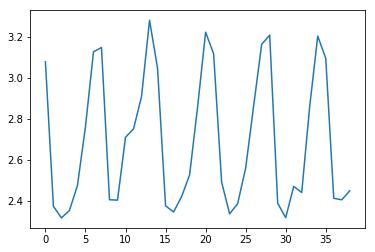

In [31]:
plt.plot(testpreds[129])

In [32]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [33]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.869539   
air_0164b9927d20bcc3_2017-04-23              1.421408   
air_0241aa3964b7f861_2017-04-23              2.245590   
air_0328696196e46f18_2017-04-23              2.128144   
air_034a3d5b40d5b1b1_2017-04-23              3.460691   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.485304  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.142951  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   8.445985  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.399265  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  30.838984

In [34]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [35]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [36]:
submission.to_csv("../submission/3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')